In [1]:
import numpy  as np 
import pandas as pd 
import os
import cv2 
import gc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, confusion_matrix

# import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.applications import DenseNet121
from keras.layers import GlobalAveragePooling2D, Dropout, Dense
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau
from keras.activations import sigmoid
from keras.optimizers import Adam

# Global constants
IMG_DIM      = 256
BATCH_SIZE   = 32
NUM_CLASSES  = 5
# NUM_CLASSES  = 3  # 2 stage models
CHANNEL_SIZE = 3

pre_process = str(IMG_DIM) + "_ben_normal_"

# pre_process = "ben_weird_"

# pre_process = "clahe_green_"


Using TensorFlow backend.
/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python

# Loading data

In this kernel, we are using multilabel data. Instead of predicting a single label, we will change our target to be a multilabel problem; i.e., if the target is a certain class, then it encompasses all the classes before it. E.g. encoding a class 4 retinopathy would usually be `[0, 0, 0, 1]`, but in our case we will predict `[1, 1, 1, 1]`. 

The idea is that if an eye has severe diabetic retinopathy, that also means that it has moderate and severe diabetic retinopathy

In [2]:
# data frame of current competition
df_2019 = pd.read_csv("../aptos2019/train.csv") 
df_2019.processed = df_2019.id_code.apply(lambda x: pre_process + x + ".png")
df_2019["original"]  = df_2019.id_code.apply(lambda x: x + ".png")
df_2019["processed"] = df_2019.original.apply(lambda x: pre_process + x)
# train_2019, valid_2019 = train_test_split(df_2019, test_size=0.2, shuffle=False) not for python 3.5
train_2019, valid_2019 = train_test_split(df_2019, test_size=0.2, random_state=42)

# 2019 data frame 
df_2015 = pd.read_csv("../aptos2015/trainLabels.csv") 
df_2015["original"]  = df_2015.image.apply(lambda x: x + ".jpeg")
df_2015["processed"] = df_2015.original.apply(lambda x: pre_process + x)
df_2015["diagnosis"] = df_2015.level
# train_2015, valid_2015 = train_test_split(df_2015, test_size=0.2, shuffle=False)
train_2015, valid_2015 = train_test_split(df_2015, test_size=0.2, random_state=42)

valid_2019['diagnosis'].value_counts().plot(kind='bar')
print(valid_2019[:3])
plt.title('Samples Per Class')


           id_code  diagnosis          original  \
2059  90960ddf4d14          0  90960ddf4d14.png   
1105  4e0656629d02          1  4e0656629d02.png   
818   3b018e8b7303          3  3b018e8b7303.png   

                            processed  
2059  256_ben_normal_90960ddf4d14.png  
1105  256_ben_normal_4e0656629d02.png  
818   256_ben_normal_3b018e8b7303.png  


/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Samples Per Class')

In [3]:
def label_convert(y_val):
    y_val = y_val.astype(int).sum(axis=1) - 1
    return y_val

def get_train_valid_df(year="2019", style="normal", even_distrib=True):
    
    # shuffle data so each time different samples are dropped
    if (year == "2019"):
        train = train_2019.sample(frac=1)
        valid = valid_2019.sample(frac=1)
    elif (year == "2015"):
        train = train_2015.sample(frac=1)
        valid = valid_2015.sample(frac=1)
    
    # remap from classes to smoothed version of the classes
    if style == "normal":
        train["labels"] = train.diagnosis.apply(lambda x: [i for i in range(x+1)])
        valid["labels"] = valid.diagnosis.apply(lambda x: [i for i in range(x+1)])
    elif style == "stage_1":
        train["labels"] = train.diagnosis.apply(lambda x: [i for i in range(min(x+1, 3))])
        valid["labels"] = valid.diagnosis.apply(lambda x: [i for i in range(min(x+1, 3))])
    elif style == "stage_2":
#         train = train[train.diagnosis != 0]
#         train = train[train.diagnosis != 1]
#         valid = valid[valid.diagnosis != 0]
#         valid = valid[valid.diagnosis != 1]
        train["labels"] = train.diagnosis.apply(lambda x: [i for i in range(max(x-1, 1))])
        valid["labels"] = valid.diagnosis.apply(lambda x: [i for i in range(max(x-1, 1))])
    else:
        print("Error: " + style + " style not implemented.")
        exit()

    # drop classes 
    if even_distrib:
        min_train = min(train['diagnosis'].value_counts())
        min_valid = min(valid['diagnosis'].value_counts())
        
        for diagnosis in range(0 if style != "stage_2" else 0, 5):
            indexes_train = train[train['diagnosis'] == diagnosis].index
            indexes_valid = valid[valid['diagnosis'] == diagnosis].index
            
            frac_drop_train = indexes_train.size * (1 - min_train/indexes_train.size)
            frac_drop_valid = indexes_valid.size * (1 - min_valid/indexes_valid.size)
            
            train.drop(indexes_train[:int(frac_drop_train)], inplace=True)
            valid.drop(indexes_valid[:int(frac_drop_valid)], inplace=True)

    # shuffle it for even distribution, also decrease the overall amount to a max of 4,000 
    # with a prop drop in valid
    
    frac = 1
    if train.index.size > 5000:
        frac = 5000/train.index.size
        print(frac)
    train = train.sample(frac=frac)
    valid = valid.sample(frac=frac)
    
    return train, valid

df_sample, _ = get_train_valid_df(year="2015", style="stage_2")
print(df_sample.head())

             image  level          original                        processed  \
12793  16046_right      4  16046_right.jpeg  256_ben_normal_16046_right.jpeg   
1083    1343_right      1   1343_right.jpeg   256_ben_normal_1343_right.jpeg   
23500   29703_left      4   29703_left.jpeg   256_ben_normal_29703_left.jpeg   
27527  34844_right      4  34844_right.jpeg  256_ben_normal_34844_right.jpeg   
19406   24490_left      1   24490_left.jpeg   256_ben_normal_24490_left.jpeg   

       diagnosis     labels  
12793          4  [0, 1, 2]  
1083           1        [0]  
23500          4  [0, 1, 2]  
27527          4  [0, 1, 2]  
19406          1        [0]  


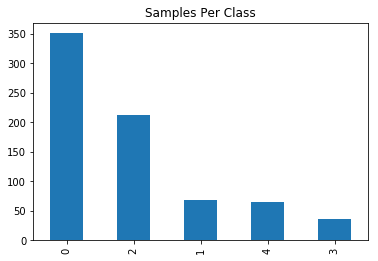

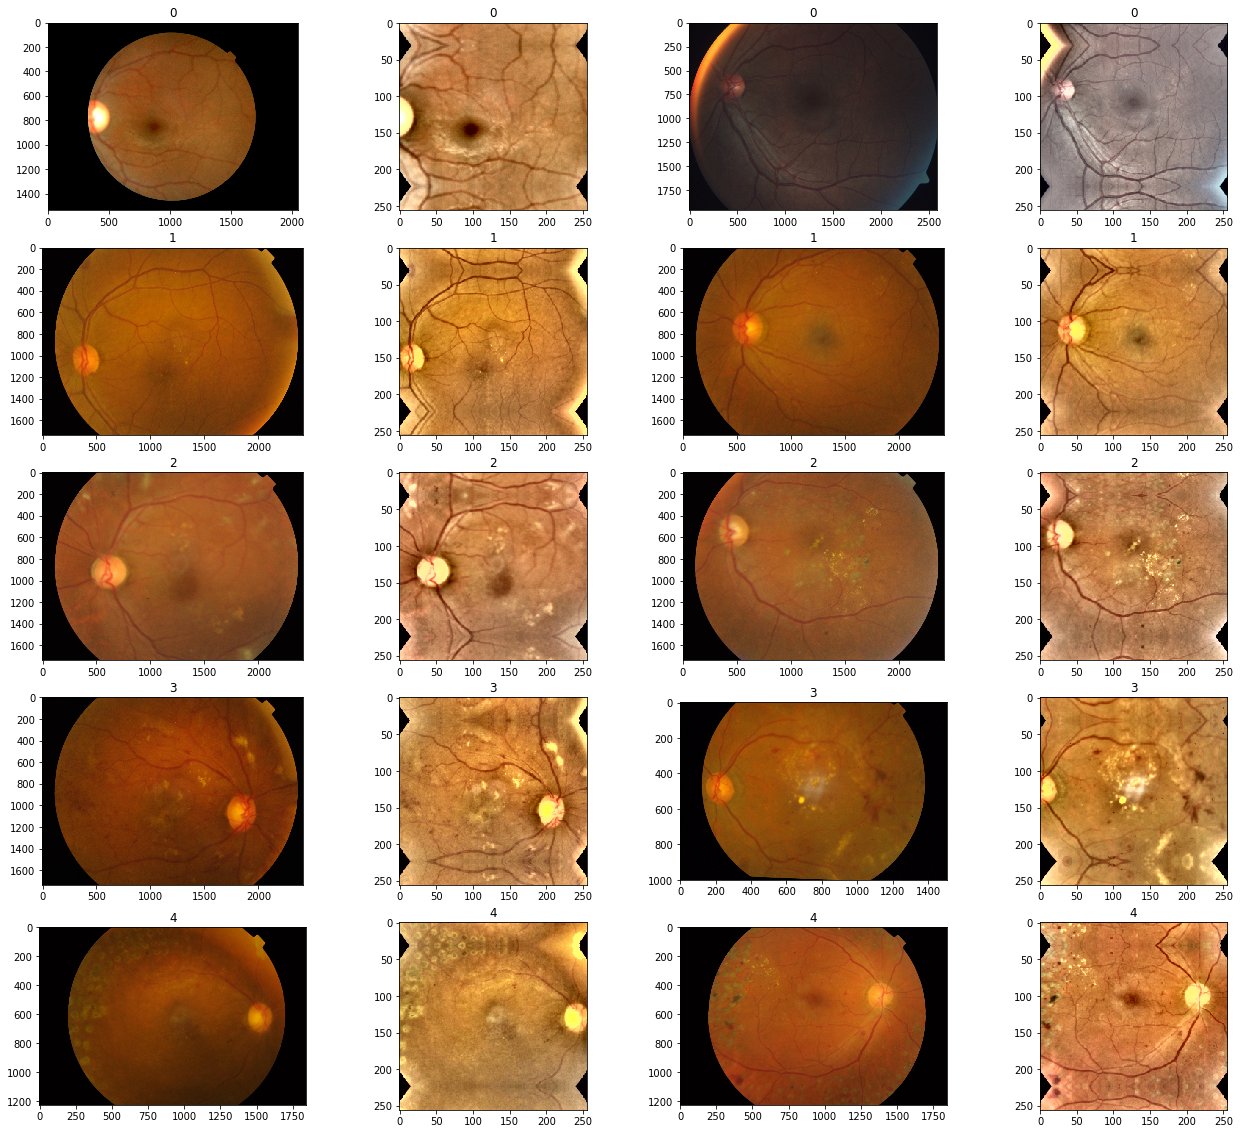

In [4]:
# display some data
def display_data():
    df_example, _ = get_train_valid_df(year="2019")

    # Display some random images from Data Set with class categories.
    figure=plt.figure(figsize=(22,20))
    for target_class in range(5):
        for i, file_name in enumerate(df_example[df_example.diagnosis == target_class].original.sample(2)):
            
            # open the file
            o_img = cv2.imread("../aptos2019/train_images/" + file_name)
            p_img = cv2.imread("../aptos2019/train_images/" + pre_process + file_name)

            o_rgb = cv2.cvtColor(o_img, cv2.COLOR_BGR2RGB)
            p_rgb = cv2.cvtColor(p_img, cv2.COLOR_BGR2RGB)
            
            ax = figure.add_subplot(5,4, int(target_class)*4+2*i+1)
            plt.imshow(o_rgb)
            ax.set_title(target_class)
            
            ax = figure.add_subplot(5,4, int(target_class)*4+2*i+2)
            plt.imshow(p_rgb)
            ax.set_title(target_class)
    
    plt.show()
            
display_data()

In [5]:
# Data generators, which put their data into a random crop generator, which is then fed into
# the network during training

def dataGenerator(jitter=0.1):
    datagen = image.ImageDataGenerator(rescale=1./255,
                                       horizontal_flip=True and (jitter > 0.01), 
                                       vertical_flip=True and (jitter > 0.01),
                                       rotation_range=int(600*jitter),
                                       brightness_range=[1-jitter/3, 1+jitter/3],
                                       channel_shift_range=int(30*jitter),
                                       zoom_range=[max(0.9, 1-5*jitter), 1],
                                       fill_mode="mirror",
                                      )
    return datagen

def datagen_with_flow(datagen, dataframe, directory):
    return datagen.flow_from_dataframe(dataframe=dataframe, directory=directory,
                                       x_col="processed", 
                                       y_col='labels', 
                                       class_mode="categorical", 
                                       batch_size=BATCH_SIZE,
                                       target_size=(IMG_DIM, IMG_DIM),
                                       shuffle=False,
                                      )

def generator(jitter=0.1, year="2019", even_distrib=True, style="normal"):
    
    train, valid = get_train_valid_df(year=year, even_distrib=even_distrib, style=style) 
    datagen_jittered = dataGenerator(jitter)
    datagen_clean = dataGenerator(0.02)
    
    train_gen = datagen_with_flow(datagen_jittered, train, "../aptos" + year + "/train_images/")
    valid_gen = datagen_with_flow(datagen_clean, valid, "../aptos" + year + "/train_images/")
    
    return train_gen, valid_gen

gc.collect()


41974

Found 785 validated image filenames belonging to 5 classes.
Found 181 validated image filenames belonging to 5 classes.


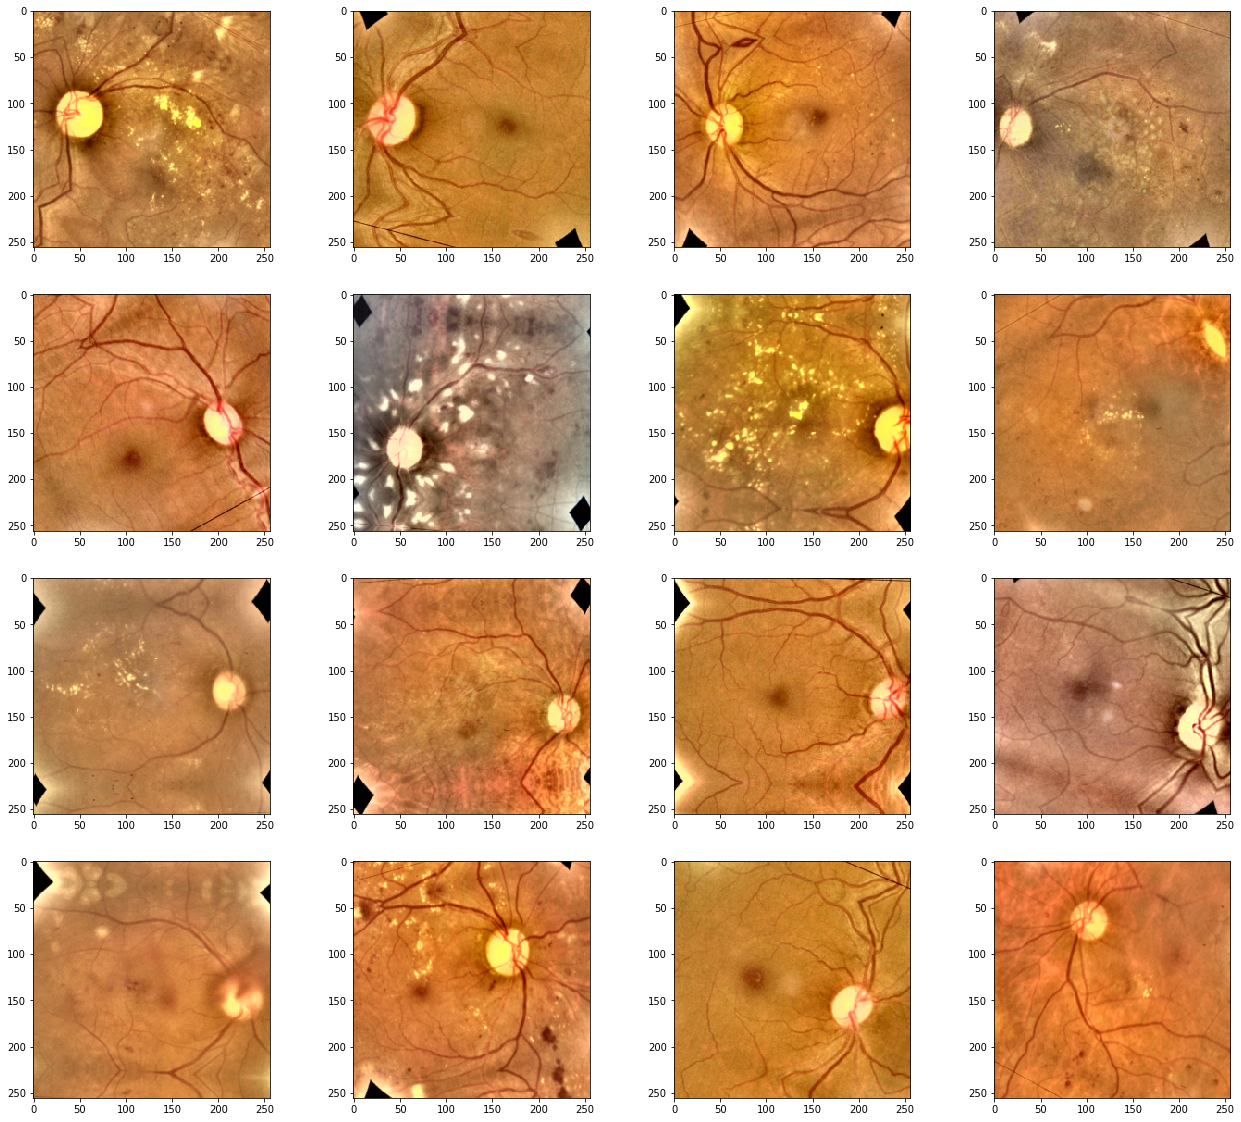

In [6]:
train_sample_gen, valid_sample_gen = generator(jitter=0.05, style="normal")

# Display some data generation
figure=plt.figure(figsize=(22,20))
for batch in train_sample_gen:
    for j in range(16):
        ax = figure.add_subplot(4,4, j+1)
        batch[0][j] = np.clip(batch[0][j], 0, 1)
        plt.imshow(batch[0][j])
    break
plt.show()

In [18]:
class Metrics(Callback):
    def __init__(self, generator, style):
        self.style = style
        self.generator = generator
        
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        
        numBatches = 20
        y_pred     = []
        y_val      = []
        for x, y in self.generator:
            predictions = model.predict(x) 
            y_pred.extend(label_convert(predictions > 0.5))
            y_val.extend(label_convert(y))
            
            numBatches -= 1
            if numBatches <= 0:
                break
            
        val_kappa = cohen_kappa_score(y_val, y_pred, weights='quadratic')
        self.val_kappas.append(val_kappa)
        
        print(confusion_matrix(y_val, y_pred), val_kappa)
            
        if val_kappa == max(self.val_kappas) and val_kappa > 0.88:
#         if val_kappa == max(self.val_kappas) and val_kappa > 0.85:
            gc.collect()
            print("Max of this run, saving model.")
            model.save(self.style + "_" + str(val_kappa) + ".h5")


In [8]:
def create_model():
    
    model = Sequential()
#     model.add(DenseNet121(weights='../DenseNet-BC-121-32-no-top.h5', 
    model.add(DenseNet121(weights=None, 
                          include_top=False, 
                          input_shape=(IMG_DIM, IMG_DIM, CHANNEL_SIZE)))
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.4))
    model.add(Dense(NUM_CLASSES, activation='sigmoid'))
    
    return model

model = create_model()
model.load_weights("normal_end_2015.h5")
# model.load_weights("ben_weird_-0.8784.h5")



In [19]:

model.load_weights("normal_end_2015.h5")
lr
for style in ["normal"]:
    for year in ["2019", "2015", "2019"]:
        for jitter in [0.5, 0.2, 0.05]:

            model.compile(optimizer=Adam(lr=0.00002*jitter), loss='binary_crossentropy',  metrics=['accuracy'])
            # started at 0.00003. Seems to still change somewhat with even 0.000005

            print("           -----------------------------------", year, 
                  jitter, "-----------------------------------")

            for even_distrib in [True, True, False]:

                print("           -   -   -   -   -   -   -   -   ", 
                      even_distrib, "-   -   -   -   -   -   -   -   -")

                # these need to be global for the kappa callback
                train_generator, valid_generator = generator(jitter=jitter, 
                                                             year=year, 
                                                             even_distrib=even_distrib, 
                                                             style=style)

                # Call backs during training            
                kappa_callbacks = Metrics(valid_generator, style)
                reduce_lr  = ReduceLROnPlateau(monitor='val_loss', 
                                               min_delta=0.0004, 
                                               patience=2, 
                                               min_lr=1e-8, 
                                               mode='auto', verbose=1)

                # train the model for 12 epochs
                history = model.fit_generator(generator=train_generator,
                                              steps_per_epoch=train_generator.n  // train_generator.batch_size,
                                              validation_data=valid_generator,
                                              validation_steps=valid_generator.n // valid_generator.batch_size,
                                              epochs=3, workers=4, verbose=1,
                                              callbacks=[reduce_lr, kappa_callbacks],
                                             )

            gc.collect()
            model.save(style + year + str(jitter) + ".h5")

           ----------------------------------- 2015 0.5 -----------------------------------
           -   -   -   -   -   -   -   -    True -   -   -   -   -   -   -   -   -
Found 2813 validated image filenames belonging to 5 classes.
Found 725 validated image filenames belonging to 5 classes.


/anaconda/envs/py35/lib/python3.5/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 2 invalid image filename(s) in x_col="processed". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Epoch 1/3
87/87 [==============================] - 160s 2s/step - loss: 0.2651 - acc: 0.8814 - val_loss: 0.2592 - val_acc: 0.8807
[[54 63  9  0  1]
 [34 71 20  3  0]
 [ 8 56 39 20  3]
 [ 2 13 24 79 16]
 [ 0  0 20 35 70]] 0.777355675366797
Epoch 2/3
87/87 [==============================] - 135s 2s/step - loss: 0.2538 - acc: 0.8867 - val_loss: 0.2584 - val_acc: 0.8794
[[29 85 11  0  2]
 [16 80 29  1  1]
 [ 3 53 43 22  7]
 [ 0  7 26 76 14]
 [ 0  2 12 34 76]] 0.7724715984014688
Epoch 3/3
87/87 [==============================] - 135s 2s/step - loss: 0.2510 - acc: 0.8875 - val_loss: 0.2594 - val_acc: 0.8799
[[40 71 16  0  1]
 [17 81 25  1  0]
 [ 7 44 38 24  6]
 [ 1 10 26 79 14]
 [ 0  2 17 35 74]] 0.7673465549030631
           -   -   -   -   -   -   -   -    True -   -   -   -   -   -   -   -   -
Found 2815 validated image filenames belonging to 5 classes.
Found 725 validated image filenames belonging to 5 classes.
Epoch 1/3
87/87 [==============================] - 137s 2s/step - loss: 0.258

/anaconda/envs/py35/lib/python3.5/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="processed". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2814 validated image filenames belonging to 5 classes.
Found 725 validated image filenames belonging to 5 classes.
Epoch 1/3
87/87 [==============================] - 137s 2s/step - loss: 0.2611 - acc: 0.8813 - val_loss: 0.3520 - val_acc: 0.8446
[[96 26  5  0  0]
 [78 43  9  0  0]
 [41 38 39 13  2]
 [14 11 36 57  5]
 [12  7 22 34 52]] 0.6490155867846374
Epoch 2/3
87/87 [==============================] - 136s 2s/step - loss: 0.2512 - acc: 0.8901 - val_loss: 0.2942 - val_acc: 0.8719
[[80 40  6  0  0]
 [50 53 16  1  0]
 [24 37 45 21  3]
 [ 7  9 26 76 10]
 [ 4  2 18 39 62]] 0.748146221224189
Epoch 3/3
87/87 [==============================] - 136s 2s/step - loss: 0.2471 - acc: 0.8907 - val_loss: 0.2694 - val_acc: 0.8808
[[72 47 13  0  0]
 [42 53 26  1  0]
 [13 35 46 26  3]
 [ 3 12 22 79 12]
 [ 1  3 17 35 68]] 0.7720938062443241
           -   -   -   -   -   -   -   -    False -   -   -   -   -   -   -   -   -
0.17793594306049823
Found 5000 validated image filenames belonging to 5 clas

           ----------------------------------- 2019 0.2 -----------------------------------
           -   -   -   -   -   -   -   -    True -   -   -   -   -   -   -   -   -
Found 785 validated image filenames belonging to 5 classes.
Found 181 validated image filenames belonging to 5 classes.
Epoch 1/3
24/24 [==============================] - 63s 3s/step - loss: 0.3044 - acc: 0.8713 - val_loss: 0.2678 - val_acc: 0.8863
[[115   2   0   0   0]
 [ 27  62  35   0   0]
 [ 10  13  94   2   0]
 [  0   4  67  36  16]
 [  0   1  56  35  32]] 0.7765820158072833
Epoch 2/3
24/24 [==============================] - 37s 2s/step - loss: 0.2510 - acc: 0.8941 - val_loss: 0.3139 - val_acc: 0.8617
[[121   3   0   0   0]
 [ 31  63  24   0   0]
 [ 13  18  88   1   0]
 [  0   1  72  28  15]
 [  1   2  64  33  29]] 0.757815318575494
Epoch 3/3
24/24 [==============================] - 37s 2s/step - loss: 0.2248 - acc: 0.9102 - val_loss: 0.2766 - val_acc: 0.8913

Epoch 00003: ReduceLROnPlateau reducing learning

[[116   2   0   0   0]
 [  4  85  27   1   0]
 [  3  16  69  30   1]
 [  0   0  24  83  19]
 [  0   5  32  48  42]] 0.8378776295836298
Epoch 3/3
24/24 [==============================] - 36s 2s/step - loss: 0.1940 - acc: 0.9163 - val_loss: 0.2153 - val_acc: 0.9141

Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
[[119   1   0   0   0]
 [  3  86  27   4   0]
 [  4   6  76  31   2]
 [  0   1  19  78  18]
 [  0   3  31  42  45]] 0.845637949836423
           -   -   -   -   -   -   -   -    False -   -   -   -   -   -   -   -   -
Found 2929 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.
Epoch 1/3
91/91 [==============================] - 142s 2s/step - loss: 0.1723 - acc: 0.9250 - val_loss: 0.1991 - val_acc: 0.9168
[[265  38   4   3   1]
 [  1  23  24   9   1]
 [  0   5  90  79   9]
 [  0   0   5  19   7]
 [  0   0   4  23  30]] 0.8591125497424141
Epoch 2/3
91/91 [==============================] - 

In [15]:
model.save("normal_end_2019.h5")

In [16]:
def prediction_convert(predictions, thresholds):
    
    thresholded = np.zeros(predictions.shape)
    
    for i in range(NUM_CLASSES):
        thresholded[:,i] = predictions[:,i] > thresholds[i]
    y_val = thresholded.astype(int).sum(axis=1) - 1
    return y_val

def prediction_convert_two_stage(stage_1_preds, stage_2_preds, thresholds):
    
    thresh_1 = np.zeros((stage_1_preds.shape[0], 3))
    thresh_2 = np.zeros((stage_2_preds.shape[0], 3))
    
    for i in range(3):
        thresh_1[:,i] = stage_1_preds[:,i] > thresholds[i]
        thresh_2[:,i] = stage_2_preds[:,i] > thresholds[i+3]
    
    y_val   = thresh_1.astype(int).sum(axis=1) - 1
    y_val_2 = thresh_2.astype(int).sum(axis=1) + 1
    
    for i in range(stage_1_preds.shape[0]):
        if y_val[i] == 2:
            y_val[i] = y_val_2[i]
    return y_val

def find_best_thresholds(stage_1_preds):
    
    y_actual = valid_2019.diagnosis.astype(int).values
    
    gc.collect()
    
    thresholds = [0.5 for i in range(5)]
    d_thresh = 0.25
    
    for sweep in range(len(thresholds)):

        for label in range(len(thresholds)):
            
            currKappa = cohen_kappa_score(y_actual, prediction_convert(stage_1_preds, thresholds), weights='quadratic')
            
            print(currKappa)
            
            thresholds[label] += d_thresh
            kappaUp = cohen_kappa_score(y_actual, prediction_convert(stage_1_preds, thresholds), weights='quadratic')
            
            thresholds[label] -= 2*d_thresh
            kappaDown = cohen_kappa_score(y_actual, prediction_convert(stage_1_preds, thresholds), weights='quadratic')
            
            thresholds[label] += d_thresh
            
            if kappaUp > currKappa:
                thresholds[label] += d_thresh
                print(confusion_matrix(y_actual, prediction_convert(stage_1_preds, thresholds)))
            elif kappaDown > currKappa:
                thresholds[label] -= d_thresh
                print(confusion_matrix(y_actual, prediction_convert(stage_1_preds, thresholds)))
                

        d_thresh /= 2
    
    gc.collect()
    return thresholds

# get the best thresholds (expensive operation, didn't yeild much improvement)
# subset_valid = valid_2019[:]
# subset_valid.diagnosis = valid_2019.diagnosis.astype(str)
# d_gen = dataGenerator().flow_from_dataframe(dataframe=subset_valid, 
#                                             directory="../aptos" + year + "/train_images/", 
#                                             x_col="processed", 
#                                             y_col='diagnosis', 
#                                             target_size=(IMG_DIM, IMG_DIM),
#                                             shuffle=False,
#                                            )

# make test predictions
# model.load_weights("stage_1_0.9161997108934691.h5")
# stage_1_preds = model.predict_generator(d_gen)

# model.load_weights("stage_22019.h5")
# stage_2_preds = model.predict_generator(d_gen)
# print(stage_1_preds[:5])
# print(stage_2_preds[:5])
# print(prediction_convert(stage_1_preds, stage_2_preds, [0.5 for i in range(6)])[:5])
best_thresholds = find_best_thresholds(stage_1_preds)
print(best_thresholds)


0.8552055792934802
0.8552055792934802
[[346   1   3   0   1]
 [ 11   8  35  13   1]
 [  3   5  71 123  11]
 [  0   1   1  27   7]
 [  0   0   4  35  26]]
0.866626284796701
[[346   3   1   1   0]
 [ 12  21  22  12   1]
 [  3  20  56 123  11]
 [  0   1   1  27   7]
 [  0   1   4  34  26]]
0.8673610101146824
[[346   3   2   0   0]
 [ 12  22  32   2   0]
 [  3  20 142  40   8]
 [  0   1  12  16   7]
 [  0   2  18  21  24]]
0.8788616676485493
[[346   4   1   0   0]
 [ 12  22  33   1   0]
 [  3  20 145  43   2]
 [  0   1  12  19   4]
 [  0   2  19  29  15]]
0.8814515737288015
0.8814515737288015
0.8814515737288015
0.8814515737288015
[[346   3   2   0   0]
 [ 12  22  29   5   0]
 [  3  20 102  86   2]
 [  0   1   8  23   4]
 [  0   1   9  39  16]]
0.8834722841638731
[[346   3   2   0   0]
 [ 12  22  28   6   0]
 [  3  20 102  85   3]
 [  0   1   8  21   6]
 [  0   1   9  33  22]]
0.8846957309629978
0.8846957309629978
0.8846957309629978
[[346   4   1   0   0]
 [ 12  30  20   6   0]
 [  3  26  9